# Trending Youtube Video Analysis 
#### by Sam Logsdon, Maryam Bokhari, and Jeong Rae Park

# Loading Data from the Database 
This will initialize the database if your directories are setup according to the readme. 

In [1]:
import db
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path

DB_PATH = 'db.sqlite'
DATA_PATH = 'data'

if not (os.path.exists(DB_PATH)):
    import db_loader
    skipped = db_loader.run(DATA_PATH, DB_PATH)
    

db = db.DB(DB_PATH)
base_df = db.fetch_videos_as_df() # make a copy of this using base_df.copy()
categories = db.fetch_categories()

---

# Question 1

## Shared Videos Between Countries

We are interested in viewing the proportion of shared trending videos between countries. The data for this analysis was calculated using a self-join of the videos table in sqlite on the basis of video_id and trending_date. The country was selected from each side of the join as well, and rows where both countries were the same were excluded. 

In [2]:
import os.path

SQL = '''
SELECT v1.country c1, v2.country c2, count(*) videos
             FROM video v1
                      JOIN video v2
                           ON (v2.video_id = v1.video_id) AND (v2.trending_date = v1.trending_date)
             WHERE c1 != c2
GROUP BY c1, c2
'''
rows = db.conn.execute(SQL).fetchall()
df = pd.DataFrame.from_records(data = rows, columns=['c1', 'c2', 'videos'])
df.head()

,c1,c2,videos
0,CA,DE,7428
1,CA,FR,5545
2,CA,GB,2159
3,CA,IN,3053
4,CA,JP,866


In [3]:
total_videos_df = base_df.groupby(level=[0]).agg(total_videos=('views', 'count'))
total_videos_df.join(df.set_index('c1'), rsuffix='c1').join(df.set_index('c2'), lsuffix='_c1',rsuffix='_c2')

,total_videos,c2,videos_c1,c1,videos_c2
CA,40881,DE,7428,DE,7428
CA,40881,DE,7428,FR,5545
CA,40881,DE,7428,GB,2159
CA,40881,DE,7428,IN,3053
CA,40881,DE,7428,JP,866
...,...,...,...,...,...
US,40949,RU,219,IN,697
US,40949,RU,219,JP,179
US,40949,RU,219,KR,352
US,40949,RU,219,MX,598


In [4]:

total_videos_df['key'] = 0
vddf = total_videos_df.reset_index().merge(total_videos_df.reset_index(), on='key').drop('key', axis=1).set_index(['country_x', 'country_y'])
vddf.index = vddf.index.rename(['c1', 'c2'])
df = df.set_index(['c1', 'c2']).join(vddf)

In [5]:

df['total_videos'] = df.total_videos_x + df.total_videos_y
df['shared_percent'] = df.videos / df.total_videos 


## Pivoted Dataframe
We use the pandas pivot function to reshape our data. Note that the data is mirrored across the line of missing(nan) values. This is because the self-join query returned data for (c1,c2) and (c2,c1) pairs e.g. (US,RU) and (RU,US). We will clean this up in the next step. 

In [6]:
pv = df.reset_index().pivot(index='c1', columns='c2', values='shared_percent')
pv.rename_axis(None).style.set_table_styles([{'selector': '.index_name', 'props': [('font-size', '0')]}])

c2,CA,DE,FR,GB,IN,JP,KR,MX,RU,US
CA,nan,0.0908946,0.0679493,0.0270562,0.0390245,0.0141033,0.0120613,0.0251316,0.00891938,0.0588782
DE,0.0908946,nan,0.0622456,0.0110713,0.017764,0.0104949,0.00763855,0.0211216,0.0279116,0.0205529
FR,0.0679493,0.0622456,nan,0.0081115,0.0170475,0.0102699,0.00622916,0.0203634,0.0134049,0.0108849
GB,0.0270562,0.0110713,0.0081115,nan,0.00510044,0.00237218,0.00449083,0.00548087,0.00271169,0.0792713
IN,0.0390245,0.017764,0.0170475,0.00510044,nan,0.0178661,0.0202033,0.0233924,0.0207066,0.00890155
JP,0.0141033,0.0104949,0.0102699,0.00237218,0.0178661,nan,0.0264113,0.0203529,0.0168457,0.00291189
KR,0.0120613,0.00763855,0.00622916,0.00449083,0.0202033,0.0264113,nan,0.018129,0.0187767,0.00466126
MX,0.0251316,0.0211216,0.0203634,0.00548087,0.0233924,0.0203529,0.018129,nan,0.0240424,0.00734644
RU,0.00891938,0.0279116,0.0134049,0.00271169,0.0207066,0.0168457,0.0187767,0.0240424,nan,0.00268093
US,0.0588782,0.0205529,0.0108849,0.0792713,0.00890155,0.00291189,0.00466126,0.00734644,0.00268093,nan


## Generated heatmap

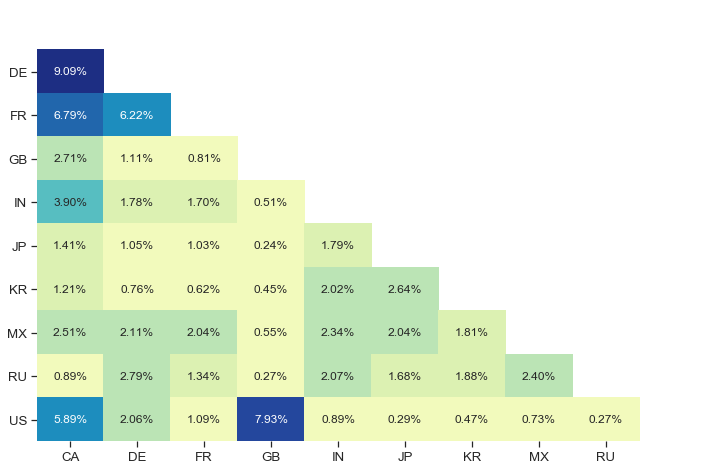

In [7]:
sns.set(style="ticks", font_scale=1.2)
%matplotlib inline
plt.figure(figsize=(12,8)) 


mask = np.zeros_like(pv, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(pv, cmap = sns.color_palette("YlGnBu", 10), 
                 annot=True, annot_kws = {'size': 'large'}, fmt='.2%',
                 mask = mask,
                 cbar = False
                )
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

ax.xaxis.get_major_ticks()[-1].set_visible(False)
ax.yaxis.get_major_ticks()[0].set_visible(False)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xlabel('')
ax.set_ylabel('');

## Average proportion of shared videos

In [8]:
df.groupby('c1').aggregate(
    average_shared=('shared_percent', 'mean')).sort_values(by='average_shared',ascending=False)

,average_shared
c1,
CA,0.038224
DE,0.029966
FR,0.024056
US,0.021788
IN,0.018890
MX,0.018373
GB,0.016185
RU,0.015111
JP,0.013514


---

# Question 2

## Average time for video to go from viewable to trending

In [9]:
m = base_df.copy()

The preprocessing for this question required us to drop duplicate Video Id's such that we keep the first instance after we sort the data.

Sample Video ID (Before Pre-processing): 

| Video ID   |   Trending Date   | Publish Date |
|----------|-------------|------|
| 1 |  2018-09-01. | 2018-09-01 |
| 1 |  2018-09-02.  |   2018-09-01|
| 1 |  2018-09-03.  |   2018-09-01 |


Sample Video ID (After Pre-processing): 

| Video ID   |   Trending Date   | Publish Date |
|----------|-------------|------|
| 1 |  2018-09-01. | 2018-09-01 |


In [10]:
#Pre processing data- Dropping Duplicate Values and handling null values 
m = m.sort_values(by=['country', 'video_id', 'trending_date'])
group = m.groupby(level=[1])
m = group.first()

The trending age wascalculated by subtracting the trending time with the publish time. 

In [11]:
m['trending_date']=m['trending_date'].dt.normalize()
m['publish_time']=m['publish_time'].dt.normalize()
m['time_to_trending']= m['trending_date'].sub(m['publish_time'])
m['time_to_trending'].describe()
m['time_to_trending'] = m['time_to_trending'].dt.days

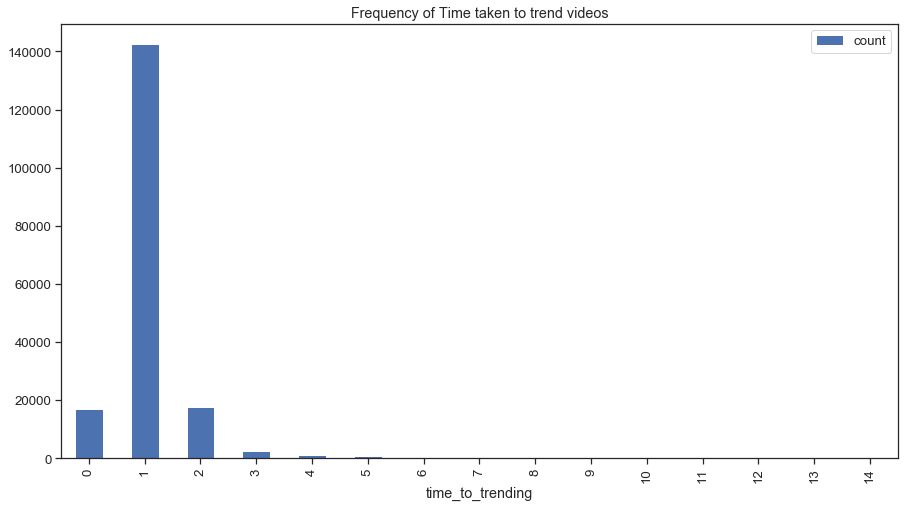

In [12]:
#plotting the first most frequent timings
import matplotlib.pyplot as plt
import scipy.stats

counts = m.groupby('time_to_trending').agg(count=('likes', 'count')).sort_values(by='time_to_trending')
#y=m['time_to_trending'].sort_values().value_counts()#[:10]
counts[:15].plot(kind='bar', title="Frequency of Time taken to trend videos", figsize=(15,8))


It's a shame we don't have a higher resolution for trending_date to get a proper sense of the distribution. From this view, it looks like it could be normally distributed, but the shape could change significantly if we zoomed in.

In [13]:
#Data distribution
maxi=m['publish_time'].max()
mini=m['publish_time'].min()
print(mini, '-', maxi)
print(m['trending_date'].count() )

2006-07-23 00:00:00+00:00 - 2018-06-14 00:00:00+00:00
184287


In [14]:
#taking a year with the most number of published videos 
avg=m.groupby(by=[m.publish_time.dt.year]).count()
avg

,comment_count,trending_date,channel_title,comments_disabled,publish_time,title,category_id,dislikes,likes,video_error_or_removed,views,ratings_disabled,time_to_trending
publish_time,,,,,,,,,,,,,
2006,1,1,1,1,1,1,1,1,1,1,1,1,1
2007,3,3,3,3,3,3,3,3,3,3,3,3,3
2008,9,9,9,9,9,9,9,9,9,9,9,9,9
2009,12,12,12,12,12,12,12,12,12,12,12,12,12
2010,16,16,16,16,16,16,16,16,16,16,16,16,16
2011,20,20,20,20,20,20,20,20,20,20,20,20,20
2012,16,16,16,16,16,16,16,16,16,16,16,16,16
2013,34,34,34,34,34,34,34,34,34,34,34,34,34
2014,35,35,35,35,35,35,35,35,35,35,35,35,35


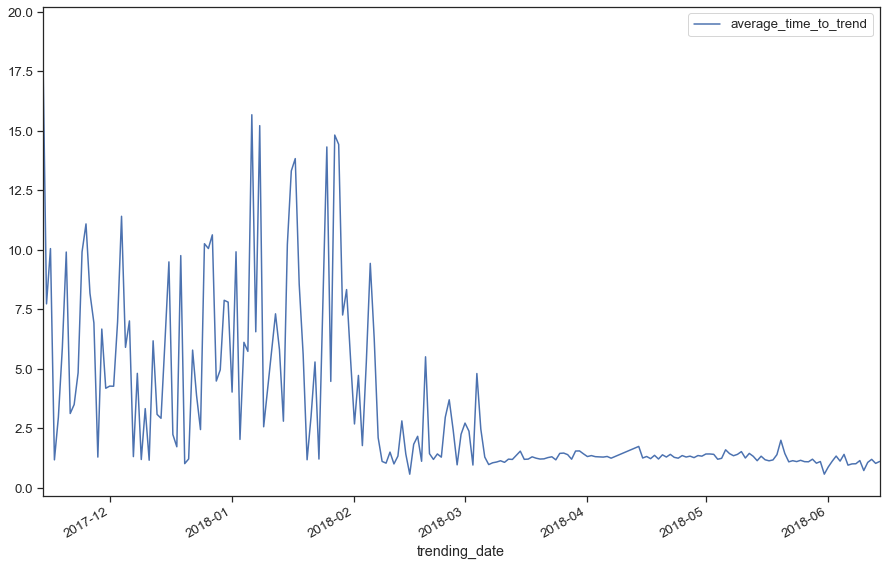

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
grouped = m.groupby('trending_date').agg(average_time_to_trend=('time_to_trending', 'mean'), 
                                         error=('time_to_trending', 'std'), 
                                         mad=('time_to_trending', 'mad'))
grouped.plot(kind='line', y='average_time_to_trend',figsize=(15,10))
plt.show()

Youtube has clearly made some changes to their trending algorithm to prefer more recent content. Before the change, videos from as early as 2006 could trend on the basis of just a few hundred views, causing a huge variance in age. 

---

# Question 3

# What type of video category is most likely to become trending.

We are interested in viewing list of categories which is most likely to become trending.


In [16]:
q3 = base_df.copy()

With this process, we can count number of vedio in each category in each countries.

In [17]:
q3 = q3.groupby(['country', 'category_id']).agg(
    count = ('likes', 'count')
)
q3

count
country category_id       
CA      1             2060
        2              353
        10            3731
        15             369
        17            2787
...                    ...
US      26            4146
        27            1656
        28            2401
        29              57
        43              57

[167 rows x 1 columns]

With this code, we can sort the data by count which is number of video and give a rank based on count.
After that, we only pull out the top 5 from each group

In [18]:
q3 = q3.sort_values(by=['country', 'count'], ascending=False)
temp_df = q3.groupby(['country']).agg(rank = ('count', 'cumcount'))
q3 = pd.merge(q3, temp_df, left_index=True, right_index=True)
q3 = q3.join(categories.set_index('id'), on=['category_id'])


In this code, we join two data, q3 and category. 
After that, we aggregated all number of videos in categories which are not in top 6, and renamed the category id as "99" and ranked it as "7". 

In [19]:
#delete this block before submitting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

bottom = q3[q3['rank']>6].groupby(level=[0]).agg(count=('count', 'sum'))
bottom['category_id'] = 99
bottom['category'] = 'Other'
bottom['rank'] = 7
bottom = bottom.reset_index().set_index(['country', 'category_id'])
#q3 = q3[q3['rank']<=6].append(bottom, sort=True)
q3

count  rank               category  assignable
country category_id                                                
US      24            9964     0          Entertainment           1
        10            6472     1                  Music           1
        26            4146     2          Howto & Style           1
        23            3457     3                 Comedy           1
        22            3210     4         People & Blogs           1
...                    ...   ...                    ...         ...
CA      15             369    12         Pets & Animals           1
        2              353    13       Autos & Vehicles           1
        43             124    14                  Shows           0
        29              74    15  Nonprofits & Activism           1
        30               6    16                 Movies           0

[167 rows x 4 columns]

make barplot and swarmplot.
With swarmplot, we can see that rank of categories base of number of videos in each countries.
As you see, Entertainment category is popular in most countries, but not all counties.
There are similarity and difference by countries.
With barplot, we cass see that mean of number of videos in each countries.
in 5 countries, Entertainment category is outliers which means that it is way over popular than other category there.

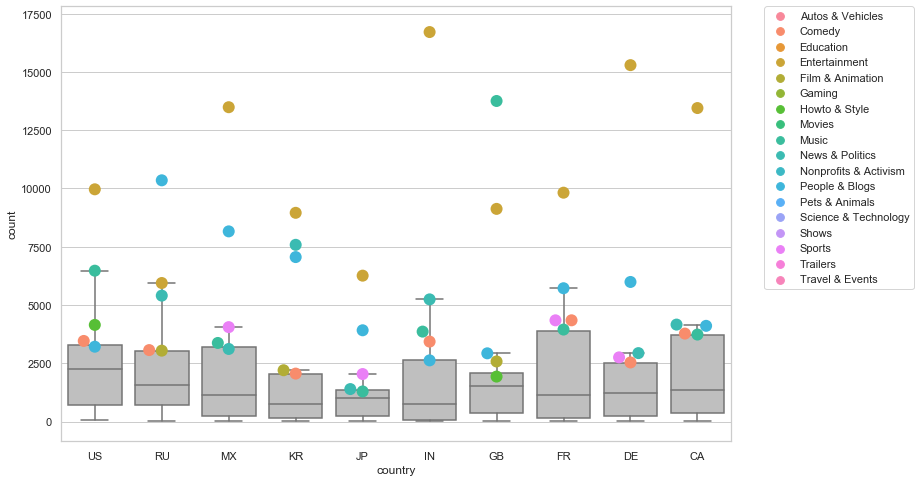

In [20]:
plt.figure(figsize=(12,8)) 
#ax = sns.barplot(x=df3.index.get_level_values(1), y="count",hue=df3.index.get_level_values(1), data=df3)
sns.boxplot(x='country', y='count', data=q3.reset_index(), color='.75')
ax = sns.swarmplot(x="country", y="count", data=q3[q3['rank']<5].reset_index(), hue='category',hue_order=q3.sort_values('category').category.drop_duplicates(), size=12)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Question 4

## Popular videos at same time in all counties

We are interested in viewing the list of popular videos trended at same time in all countries. 

The preprocessing of the data for this analysis was calculated using a self-join of the videos table in sqlite on the basis of video_id and trending_date. By using SQL, we can pull out the videos which are trended at the same time in countries.

In [21]:
from containers import YoutubeVideo

videos = []
with db.conn:
    for row in db.conn.execute("SELECT count(video_id) as c, * FROM video WHERE video_id != '#NAME?' GROUP BY trending_date, video_id ORDER BY c DESC "):
        videos.append(row)

df4 = pd.DataFrame.from_records(data=videos, columns=['c'] + list(YoutubeVideo._fields))
df4

,c,id,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,csv_row
0,15,16646,pVxOVlm_lE8,2018-02-07T00:00:00,Marvel Studios’ Avengers: Infinity War - Big G...,Marvel Entertainment,24,2018-02-05T02:12:09.000Z,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",12909876,290084,5326,26863,https://i.ytimg.com/vi/pVxOVlm_lE8/default.jpg,0,0,0,An entire universe. Once and for all. #Infinit...,MX,16645
1,15,35647,7C2z4GqqS5E,2018-05-20T00:00:00,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",62796390,4470923,119053,905925,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,0,0,0,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,MX,35646
2,13,16792,wbSwFU6tY1c,2018-02-08T00:00:00,Falcon Heavy Test Flight,SpaceX,28,2018-02-06T21:03:04.000Z,[none],14816949,300315,7802,30313,https://i.ytimg.com/vi/wbSwFU6tY1c/default.jpg,0,0,0,"When Falcon Heavy lifts off, it will be the mo...",MX,16791
3,13,34509,r-3iathMo7o,2018-05-14T00:00:00,"The ULTIMATE $30,000 Gaming PC Setup",Unbox Therapy,28,2018-05-13T19:00:25.000Z,"gaming setup|""gaming""|""setup""|""fortnite""|""fort...",3205123,74198,5439,9400,https://i.ytimg.com/vi/r-3iathMo7o/default.jpg,0,0,0,"Fortnite, PUBG, Far Cry 5? Which game would yo...",MX,34508
4,12,24123,QwievZ1Tx-8,2018-03-17T00:00:00,Marvel Studios' Avengers: Infinity War - Offic...,Marvel Entertainment,24,2018-03-16T13:02:41.000Z,"marvel|""comics""|""comic books""|""nerd""|""geek""|""s...",19716689,975783,9121,127045,https://i.ytimg.com/vi/QwievZ1Tx-8/default.jpg,0,0,0,In theaters April 27. Get your tickets now: ht...,MX,24122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323520,1,118511,zcpt8Hd66ug,2018-06-14T00:00:00,Schwanger mit 54: Nun redet Brigitte Nielsen ü...,Promiflash,24,2018-06-12T20:49:57.000Z,"Mama & Baby|""Mattia Dessi""|""Hollywood""|""Brigit...",84629,798,76,125,https://i.ytimg.com/vi/zcpt8Hd66ug/default.jpg,0,0,0,Vor wenigen Wochen überraschte Brigitte Nielse...,DE,40707
323521,1,40380,zi6TWx1_dMQ,2018-06-14T00:00:00,Geo le caya la boca a Susana Heredia - Bebeshi...,WAXTERNOC,24,2018-06-13T15:00:58.000Z,[none],71845,285,60,35,https://i.ytimg.com/vi/zi6TWx1_dMQ/default.jpg,0,0,0,,MX,40379
323522,1,118446,znUg17W526o,2018-06-14T00:00:00,Die Wahrheit über die WM 2018,MrWissen2go,22,2018-06-13T12:30:02.000Z,"wissen2go|""mrwissen2go""|""fußballweltmeistersch...",164294,9065,453,1632,https://i.ytimg.com/vi/znUg17W526o/default.jpg,0,0,0,Keine Frage - die Fußball-Weltermeisterschaft ...,DE,40642
323523,1,173595,zxFTemts_8s,2018-06-14T00:00:00,[LIVE] BTS DDAENG (땡) Suga RM Jhope PROM PARTY...,BTS WooJiHwa,22,2018-06-13T12:38:37.000Z,"bts|""bts woojihwa""|""bighit""|""jimin""|""jungkook""...",302198,25526,44,2124,https://i.ytimg.com/vi/zxFTemts_8s/default.jpg,0,0,0,,KR,34428


With Dataframe, we get the videos which has the count number over 10. It means that the video which has count number over 10 are trended in all counties at same time because we have only 10 counties data. There are some same videos twice or more being trended at the same time in all counties which is duplication, but we did not delete this duplicate because our porpose is to see the list of vedios which are become trending at the same time in all counties. 

In [22]:
df_filtered = df4.query('c>=10')
df_filtered = df_filtered.sort_values(by=['title'], ascending=False)
df_new = df_filtered[['title','channel_title','trending_date']]

# Table chart

We only pull out the some columns, title and channel_title and trending_date, and make table chart to view it.

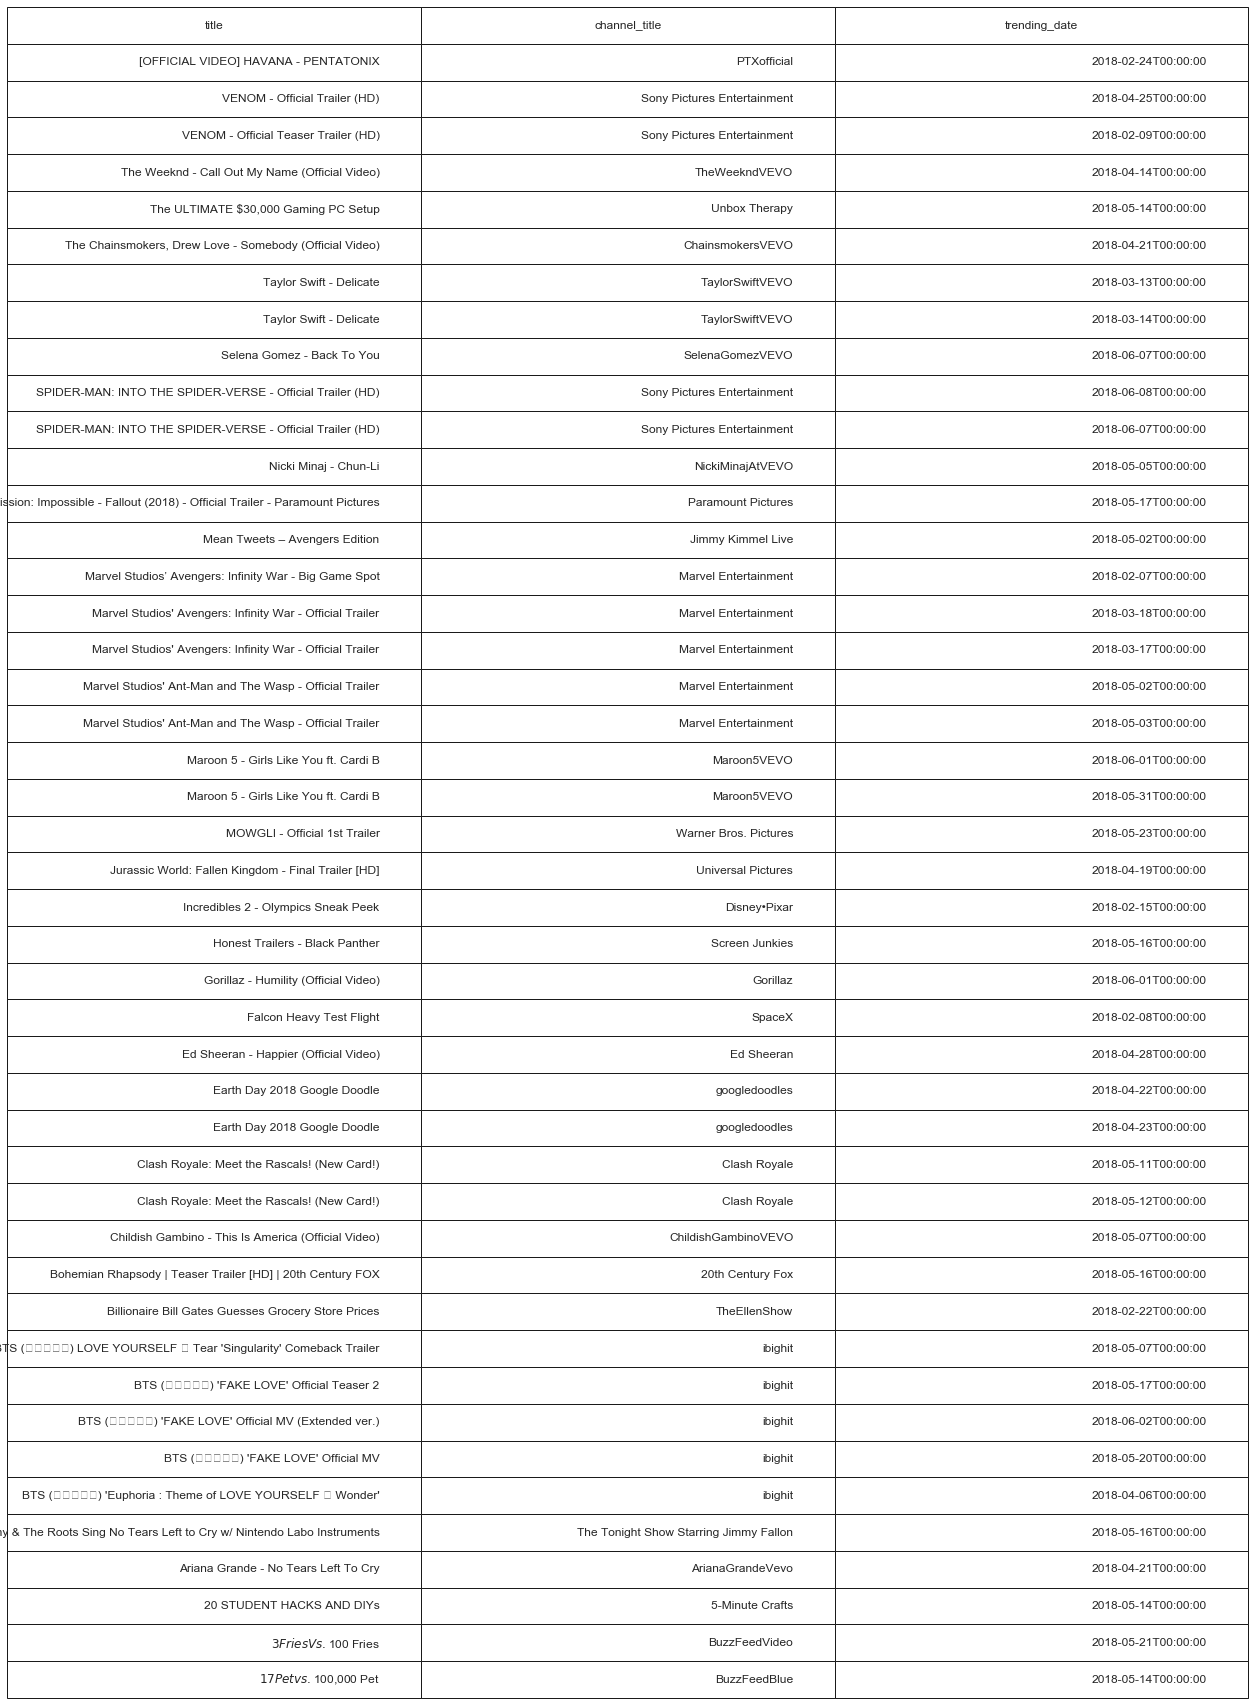

In [23]:
import warnings
warnings.filterwarnings('ignore') #supress font warnings

collabel=("title","channel_title","trending_date")

fig, ax = plt.subplots()

fig.patch.set_visible(False)

ax.axis('off')
ax.axis('tight')

table_df=ax.table(cellText=df_new.values, colLabels=collabel, loc='center')
table_df.auto_set_font_size(False)
table_df.set_fontsize(12)
table_df.scale(3.5,2.5)

fig.tight_layout()

plt.show()

# Predicting Categories With Machine Learning
We used an SGDClassifier because of the memory requirements of many other models

In [24]:
df = db.fetch_videos_as_df(exclude=['tags', 'thumbnail_link'])
df = df.reset_index().groupby('video_id').first()

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = df[['country' ,'title','description']]
target = df.category_id
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.4, random_state=0, stratify=target)

column_trans = ColumnTransformer(
     [('country_category', OneHotEncoder(), ['country']),
     ('description_t', TfidfVectorizer(), 'description')])
svm_model = make_pipeline(column_trans, SGDClassifier(loss="hinge", penalty="l2"))
svm_model.fit(X_train, target_train)
svm_labels = svm_model.predict(X_test)


print(classification_report(target_test, svm_labels))


              precision    recall  f1-score   support

           1       0.82      0.54      0.65      3691
           2       0.85      0.70      0.77      1364
          10       0.74      0.70      0.72      4207
          15       0.79      0.62      0.70       930
          17       0.69      0.79      0.74      5417
          19       0.89      0.48      0.62       340
          20       0.82      0.60      0.69      2236
          22       0.64      0.56      0.60     13308
          23       0.83      0.63      0.71      4295
          24       0.66      0.86      0.75     21170
          25       0.75      0.75      0.75      8873
          26       0.79      0.77      0.78      3897
          27       0.87      0.59      0.71      1633
          28       0.85      0.58      0.69      1389
          29       0.86      0.38      0.53       795
          30       0.00      0.00      0.00         5
          43       0.76      0.12      0.20       164
          44       0.00    

In [26]:
model = make_pipeline(TfidfVectorizer(), SGDClassifier(loss="hinge", penalty="l2"))
model.fit(X_train['description'], target_train)
labels = model.predict(X_test['description'])
print(classification_report(target_test, labels))

              precision    recall  f1-score   support

           1       0.81      0.55      0.66      3691
           2       0.84      0.72      0.78      1364
          10       0.71      0.73      0.72      4207
          15       0.84      0.63      0.72       930
          17       0.80      0.78      0.79      5417
          19       0.88      0.50      0.64       340
          20       0.83      0.61      0.70      2236
          22       0.60      0.63      0.62     13308
          23       0.82      0.66      0.73      4295
          24       0.70      0.82      0.76     21170
          25       0.73      0.76      0.75      8873
          26       0.77      0.79      0.78      3897
          27       0.88      0.61      0.72      1633
          28       0.85      0.59      0.70      1389
          29       0.81      0.41      0.55       795
          30       0.00      0.00      0.00         5
          43       0.69      0.13      0.22       164
          44       0.00    

Using description alone seems to be about the same as both description and country